In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scanpy as sc
import warnings

In [7]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data paths

## demeter

In [8]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

## gardner-lab-computer

In [9]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

# Data import

In [16]:
tabulaMurisEntropy = pd.read_csv("../analysis/Tabula_muris_TRA_entropy.csv", index_col=0)
tabulaMurisEntropy.columns = ["tabula_muris_entropy"]

# GNF1M data processing

In [86]:
gnf1mData = pd.read_csv(f"{rawDataPath}Mouse Gene Atlas/GNF1M_plus_macrophage_small.bioGPS.txt", sep="\t", index_col=0)
probes = pd.read_csv(f"{rawDataPath}Mouse Gene Atlas/GNF1M_probe_annotations.csv", index_col=0)

# remove probes with no gene symbols
probes = probes.dropna()
# remove probes that map to multiple genes
probes["multiple_genes"] = ["|" in i for i in probes.GeneSymbols] 
probes = probes[~probes.multiple_genes]

# Subset on filtered probes
gnf1mData = gnf1mData[gnf1mData.index.isin(probes.index)]
gnf1mData["gene"] = probes["GeneSymbols"]
# Avereage expression across multiple probesets for single gene
gnf1mData = gnf1mData.groupby("gene").mean()

In [87]:
# Subset on tissue samples
keep_samples = [i for i in gnf1mData.columns if "cell" not in i]
keep_samples = [i for i in keep_samples if "osteo" not in i]
keep_samples = [i for i in keep_samples if "macrophage" not in i]
keep_samples = [i for i in keep_samples if "neuro2a" not in i]
keep_samples = [i for i in keep_samples if "embryonic stem" not in i]
keep_samples = [i for i in keep_samples if "3T3" not in i]
keep_samples = [i for i in keep_samples if "M-1" not in i]
keep_samples = [i for i in keep_samples if "c2c12" not in i]
keep_samples = [i for i in keep_samples if "embryo" not in i]
gnf1mData = gnf1mData[keep_samples].T
# Average tissues with multiple replicates
gnf1mData["tissue"] = [i.split(".")[0] for i in gnf1mData.index]
gnf1mData = gnf1mData.groupby("tissue").mean().T

In [97]:
# convert to probability
gnf1mData.div(gnf1mData.sum(axis=1), axis=0)

tissueEntropy = pd.DataFrame(
    gnf1mData.apply(
        scipy.stats.entropy,
        axis=1,
        base=2
    ),
    columns=["gnf1m_entropy"]
)

In [109]:
tissueEntropy = tissueEntropy.join(tabulaMurisEntropy, how="inner")

In [110]:
tissueEntropy

,gnf1m_entropy,tabula_muris_entropy
0610009B22Rik,5.525121,4.284287
0610010K14Rik,5.661859,4.350484
0610040J01Rik,5.233187,3.525517
1110017D15Rik,3.707556,4.087790
1110032A03Rik,4.631015,4.229050
...,...,...
Zyg11b,5.614752,4.320058
Zyx,5.804331,4.295317
Zzef1,5.566501,4.284926
Zzz3,5.772614,4.329766


In [113]:
scipy.stats.spearmanr(tissueEntropy.gnf1m_entropy, tissueEntropy.tabula_muris_entropy) 

SignificanceResult(statistic=0.27330260963621666, pvalue=2.9375889014458514e-218)

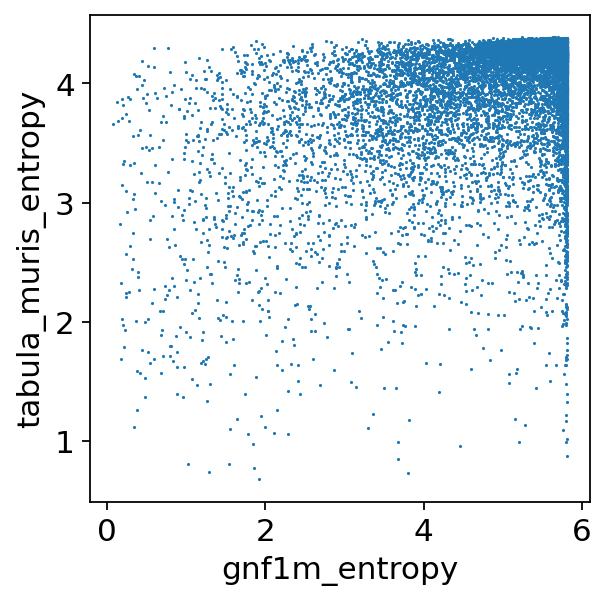

In [112]:
sns.scatterplot(
    x=tissueEntropy.gnf1m_entropy,
    y=tissueEntropy.tabula_muris_entropy,
    s=2,
    linewidth=0,
)
plt.show()